# CMPE 462 - Project 3
## Logistic Matrix Factorization

**Student IDs:** 2016749060 - 2014401015 - 2017701117

## Problem Description

Binary matrices (Matrices with elements of 0/1) appear in many applications. A binary matrix can represent relations such as 'User $i$ bought item $j$', or 'Member $i$ likes Member $j$'. Such datasets are often sparse -- only a fraction of the possible entries of a matrix are known. 

A binary matrix can also viewed as the adjacency matrix of a bipartite graph. Hence each entry corresponds to an edge.
One task here is known as link prediction, meaning guessing the presence or absence of edges in the underlying graph. 
This prediction can then be used for several tasks such as recommendation or knowledge-base completion.

In this project, you are going to implement a matrix factorization with missing elements using Stochastic Gradient Descent (SGD), Batch SGD and GD first in numpy, then also making use of PyTorch. You will also analyze the effect of the fraction of missing elements, estimation rank and max iteration. 

The matrix you will factorize is a binary(logistic) matrix and has a specific pattern. Its elements that whose indices sum up to an even number are 1 and 0 otherwise. For more detailed derivation and problem description, you can analyze [this](https://github.com/atcemgil/notes/blob/master/Logistic%20Matrix%20Factorization.ipynb) notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from __future__ import division

In [2]:
def sigmoid(t):
    return 1./(1+np.exp(-t))

# Dataset Generation

This cell generates the dataset as we have discussed. It sets the elements whom indices sum up to even number to 1.

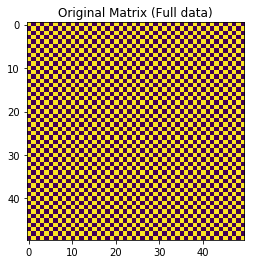

In [3]:
M = 50 # Use a square matrix of 50x50. You can change it if you wish
original_matrix = np.array([[int((i + j) % 2 == 0) for j in range(M)] for  i in range(M)])
plt.imshow(original_matrix, interpolation='nearest')  
plt.title('Original Matrix (Full data)')
plt.show()

# Masking

Now mask the dataset. Number of elements to mask is set by a parameter. 

Seed the random for repeatability

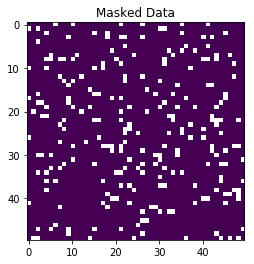

In [4]:
random.seed(10)
def generate_mask(M = 50, mask_count=M*M//10):
    masks = [(random.randint(0,M-1), random.randint(0,M-1)) for i in range(mask_count)]
    mask = np.ones((M,M))
    for m in masks:
        mask[m] = np.nan
    return mask

mask = generate_mask(M)
plt.imshow(mask, interpolation='nearest')  
plt.title('Masked Data')
plt.show()

In [5]:
Y = np.multiply(original_matrix, mask)


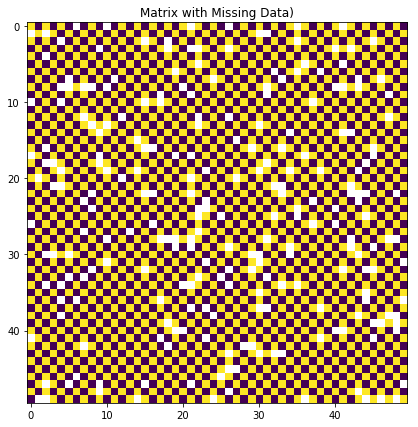

array([[  1.,   0.,   1., ...,   0.,   1.,   0.],
       [ nan,   1.,  nan, ...,   1.,   0.,   1.],
       [  1.,   0.,   1., ...,   0.,   1.,   0.],
       ..., 
       [  0.,   1.,  nan, ...,   1.,   0.,  nan],
       [  1.,   0.,   1., ...,   0.,   1.,   0.],
       [  0.,  nan,  nan, ...,   1.,  nan,   1.]])

In [6]:
plt.figure(figsize = (7,7))
plt.imshow(Y, interpolation='nearest')  
plt.title('Matrix with Missing Data)')
plt.show()
Y

In [7]:
def forward_logl(M , Y, W, H):
    WH = np.matmul(W,H)
    A = np.multiply(np.multiply(M, Y), WH) #Hadamard multiplication
    sum_A = A.sum()
    B = np.multiply(M, np.log(1 + np.exp(WH))) #Hadamard multiplication
    sum_B = B.sum()
    return(sum_A - sum_B)



In [8]:
def logl_partial_H(M, Y, W, H):
    WH = np.matmul(W,H)
    dummy = np.multiply(M,Y) - np.multiply(M,sigmoid(WH))
    grad_H = np.matmul(W.T, dummy)
    return grad_H

In [9]:
def logl_partial_W(M, Y, W, H):
    WH = np.matmul(W,H)
    dummy = np.multiply(M,Y) - np.multiply(M,sigmoid(WH))
    grad_W = np.matmul(dummy, H.T)
    return grad_W

In [10]:
def pointwise_Delta_W(M,Y,W,H, i,j):
    R = W.shape[0]
    U = W.shape[1]
    WH = np.matmul(W,H)
    DW = np.zeros((R,U))
    for r in range(R):
        for u in range(U):
            DW[r,u] = M[r,j]*Y[r,j]*H[u,j] - ( M[r,j] * (sigmoid(WH[r,j]*H[u,j])) )
    return(DW)


In [11]:
def pointwise_Delta_H(M, Y, W, H, i, j):
    R = H.shape[0]
    U = H.shape[1]
    WH = np.matmul(W,H)
    DH = np.zeros((R,U))
    for r in range(R):
        for u in range(U):
            DH[r,u] = W.T[r,i] * (M[i,u] * Y[i,u] - sigmoid(WH[i,u]))
    return(DH)

In [12]:
def plot_fit(W,H):
    Y_hat = sigmoid(np.matmul(W,H))
    plt.figure(figsize = (7,7))
    plt.imshow(Y_hat, interpolation='nearest')  
    plt.title('Estimate')
    plt.show()

# Gradient Descents

Implement **SGD**. **BGD** and **GD** in this cell using **numpy**. Compute the error of the resulting matrix compared to original data for approximation ranks in [1,M]. For measuring the quality of the fit, you should use the log-likelihood


$$ Y = \sigma(WH) $$

\begin{eqnarray}
\log p(Y |W, H ) &=& \sum_j \sum_{i} M(i,j) Y(i,j) \left(\sum_k W(i,k) H(k,j)\right)  - \sum_j \sum_{i} M(i,j) \log\left( 1+ \exp\left(\sum_k W(i,k) H(k,j)\right)\right) 
\end{eqnarray}

\begin{eqnarray}
\log p(Y |W, H )= \sum_j \sum_{i} \Bigg(\big(M\odot Y\big)\odot  (WH)\Bigg)(i,j) - \sum_j \sum_{i} \Bigg(M\odot \log\big(1 + exp(WH)\big)\Bigg)(i,j)
\end{eqnarray}



Pointwise loglikelihood:

\begin{eqnarray}
l(i,j) = M(i,j) Y(i,j) WH(i,j)-M(i,j)\log\Bigg(1 + exp(WH(i,j))\Bigg) 
\end{eqnarray}




### Derivatives of log likelihood function


\begin{eqnarray}
\frac{\partial L}{\partial H} = W^\intercal\Big[M\odot\big(y-\sigma(WH)\big)\Big]
\ = W^\intercal\Big[(M\odot y)-\big(M\odot\sigma(WH)\big)\Big]
\end{eqnarray}

\begin{eqnarray}
\frac{\partial L}{\partial W} = \Big[M\odot\big(y-\sigma(WH)\big)\Big]H^T
\ = \Big[(M\odot y)-\big(M\odot\sigma(WH)\big)\Big]H^T
\end{eqnarray}


Pointwise derivatives:

\begin{eqnarray}
\frac{\partial l(i,j)}{\partial W(r,u)}=M(r,j) Y(r,j) H(u,j) - M(r,j)\Bigg(\sigma(WH(r,j) H(u,j)\Bigg)
\end{eqnarray}

\begin{eqnarray}
\frac{\partial l(i,j)}{\partial H(r,u)} = W^T(r,i)\Bigg( M(i,u)Y(i,u)- \sigma(WH(i,u))\Bigg)
\end{eqnarray}

For plot generation, use results computed by SGD.

In [74]:
# Implement SGD here. Add the method signatures for other gradient descents as well. You can add a batch size parameter to merge
# all types of gradient descents into one method.
def sgd(original_matrix, mask, estimation_rank, max_epoch=10000,eta=0.010, nu=0.1):
    
    K = estimation_rank
    M = original_matrix.shape[0]
    Y = np.multiply(original_matrix, mask)
    Y_M = Y.copy()
    Y_M[np.isnan(Y_M)] = 999
    MM = mask.copy()  # creating a Mask matrix that is going to be used in GD.
    MM[np.isnan(MM)] = 0
    
    W = np.random.randn(M,K) # initialize here
    H = np.random.randn(K,M)  
    
    #plot_fit(W,H)  # plotting the initial guess

    sgd_error_vec = np.zeros(max_epoch) #initialize the error vec
    
    # SGD starts here 
    for e in range(max_epoch):

        j = int(round(np.random.uniform(low=0.0, high=49.0))) 
        i = int(round(np.random.uniform(low=0.0, high=49.0))) 
        dLh = pointwise_Delta_H(MM, Y_M, W, H, i, j) 
        H = H + eta * dLh 
        dLw = pointwise_Delta_W(MM, Y_M, W, H, i, j) 
        W = W + eta * dLw 


        Y_hat = sigmoid(np.matmul(W,H))
        sgd_error_vec[e] = np.linalg.norm(Y_hat - original_matrix)

#         if e % 1000 == 0:
#             #plot_fit(W,H)
#             print e
#             print sgd_error_vec[e]

#         if sgd_error_vec[e] < 3:
#             break
    
    
    #plt.plot(sgd_error_vec[0:e])
    #plt.show()
    return(W, H, sgd_error_vec)


    
    
    
    


In [41]:
def minibatch_gd(original_matrix, mask, estimation_rank, max_epoch=10000,eta=0.010, nu=0.1, B = 50):
    K = estimation_rank
    M = original_matrix.shape[0]
    Y = np.multiply(original_matrix, mask)
    Y_M = Y.copy()
    Y_M[np.isnan(Y_M)] = 999
    MM = mask.copy()  # creating a Mask matrix that is going to be used in GD.
    MM[np.isnan(MM)] = 0
    
    W = np.random.randn(M,K) # initialize here
    H = np.random.randn(K,M)  
    
    #plot_fit(W,H)  # plotting the initial guess

    minibatch_error_vec = np.zeros(max_epoch) #initialize the error vec
    
    
    # Minibatch starts here 
    for e in range(max_epoch):
        dLh=0
        dLw=0
        batch = [ ( int(round(np.random.uniform(low=0.0, high=49.0))), int(round(np.random.uniform(low=0.0, high=49.0))) ) for k in range(B) ]
        for b in range(B):
            i = batch[b][0]
            j = batch[b][1]
            dLh = dLh + pointwise_Delta_H(MM, Y_M, W, H, i, j)
            dLw = dLw + pointwise_Delta_W(MM, Y_M, W, H, i, j)

        H = H+ eta * dLh
        W = W + eta * dLw

        Y_hat = sigmoid(np.matmul(W,H))
        minibatch_error_vec[e] = np.linalg.norm(Y_hat - original_matrix)

        if e % 1000 == 0:
            #plot_fit(W,H)
            print e
            print minibatch_error_vec[e]

        if minibatch_error_vec[e] < 3:
            break
    
    
    #plt.plot(minibatch_error_vec[0:e])
    #plt.show()
    return(W,H)


    

In [30]:
# Implement SGD here. Add the method signatures for other gradient descents as well. You can add a batch size parameter to merge
# all types of gradient descents into one method.
def pointwise_gd(original_matrix, mask, estimation_rank, max_epoch=10000,eta=0.010, nu=0.1):
    K = estimation_rank
    M = original_matrix.shape[0]
    Y = np.multiply(original_matrix, mask)
    Y_M = Y.copy()
    Y_M[np.isnan(Y_M)] = 999
    MM = mask.copy()  # creating a Mask matrix that is going to be used in GD.
    MM[np.isnan(MM)] = 0

    W = np.random.randn(M,K) # initialize here
    H = np.random.randn(K,M)  # initialize here
    max_epoch = 100

    #plot_fit(W,H)  # plotting the initial guess

    error_vec = np.zeros(max_epoch)
    # Implementation of GD using pointwise gradient.

    for e in range(max_epoch):
        dLh=0
        dLw=0
        for i in range(M):
                for j in range(M):
                    dLh = dLh + pointwise_Delta_H(MM, Y_M, W, H, i, j)
                    dLw = dLw + pointwise_Delta_W(MM, Y_M, W, H, i, j)
                                

        H = H+ eta * dLh
        W = W + eta * dLw

        Y_hat = sigmoid(np.matmul(W,H))
        #plot_fit(W,H)

        print e
        error_vec[e] = np.linalg.norm(Y_hat - original_matrix)
        print error_vec[e]
        if error_vec[e] < 4:
            break

    #plt.plot(error_vec[0:e])
    #plt.show()
    return(W,H)


In [31]:
def Vector_gd(original_matrix, mask, estimation_rank, max_epoch=100,eta=0.010, nu=0.1):
    K = estimation_rank
    M = original_matrix.shape[0]
    Y = np.multiply(original_matrix, mask)
    Y_M = Y.copy()
    Y_M[np.isnan(Y_M)] = 999
    MM = mask.copy()  # creating a Mask matrix that is going to be used in GD.
    MM[np.isnan(MM)] = 0

    W = np.random.randn(M,K) # initialize here
    H = np.random.randn(K,M)  # initialize here

    #plot_fit(W,H)  # plotting the initial guess

    # Normal Gradient Descent
    error_vec = np.zeros(max_epoch)
    for epoch in range(max_epoch):
        dLh = logl_partial_H(MM, Y_M, W, H) - nu * H
        H = H + eta * dLh
        dLw = logl_partial_W(MM, Y_M, W, H) - nu * W
        W = W + eta * dLw
        Y_hat = sigmoid(np.matmul(W,H))
        #plot_fit(W,H)

        error_vec[epoch] = np.linalg.norm(Y_hat - original_matrix)
        if error_vec[epoch] < 0.5:
            break
            

    #plt.plot(error_vec[0:epoch])
    #plt.show()
    return(W,H)



0
30.7814345033
1000
7.09064923441
2000
8.16349422136


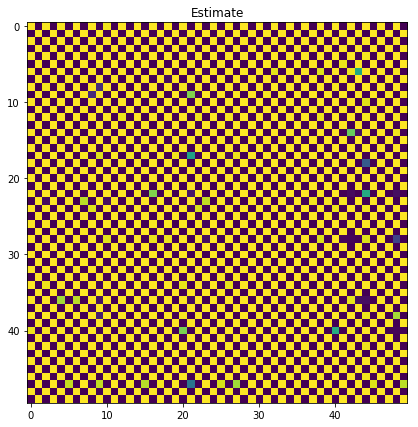

In [24]:
W,H = sgd(original_matrix = original_matrix, mask = mask, estimation_rank=10, max_epoch=10000, eta=0.010, nu=0.1 )
plot_fit(W,H)

0
27.4624072694
1
27.0352457273
2
32.8728114995
3
35.3217099891
4
34.0593084108
5
27.7636882836
6
1.54252880913


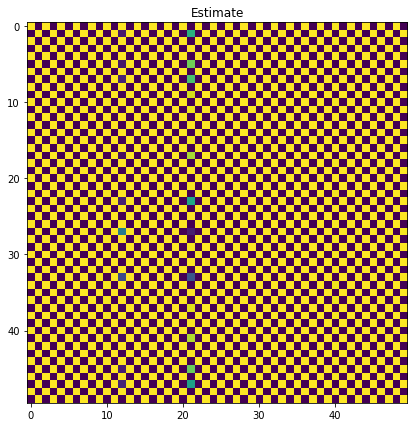

In [32]:
W,H = pointwise_gd(original_matrix = original_matrix, mask = mask, estimation_rank=2, max_epoch=10000, eta=0.001, nu=0.1 )
plot_fit(W,H)

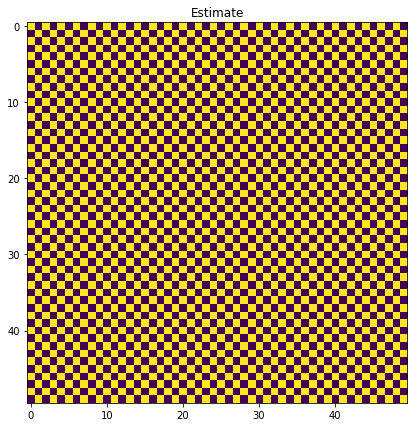

In [34]:
W,H = Vector_gd(original_matrix = original_matrix, mask = mask, estimation_rank=2, max_epoch=10000, eta=0.001, nu=0.1 )
plot_fit(W,H)

0
27.5104361553


/Users/yigitokar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


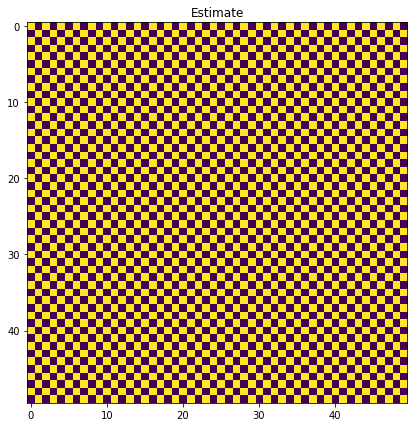

In [42]:
W,H = minibatch_gd(original_matrix, mask, 2, max_epoch=10000,eta=0.010, nu=0.1, B = 50)
plot_fit(W,H)

# Error Plots

### Error vs Estimation Rank

In [ ]:
est_ranks = np.arange(2, 51, 2)

error = []
for k in est_ranks:
    original_matrix = np.array([[int((i + j) % 2 == 0) for j in range(M)] for  i in range(M)])
    mask = generate_mask(M)
    W, H, sgd_error_tensor = SGD_PyTorch(original_matrix, mask, k , max_epoch=5000,eta=0.010)
    temp_error = sgd_error_tensor[-1]
    error.append(temp_error.data.numpy())

In [75]:
errors = []
est_ranks = np.arange(2, 51, 10)


for k in est_ranks:
    print k 
    W,H,sgd_error_vec = sgd(original_matrix = original_matrix, mask = mask, estimation_rank=k , max_epoch=5000, eta=0.010, nu=0.1)
    errors.append(sgd_error_vec[-1])
    

2


/Users/yigitokar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


12
22
32
42


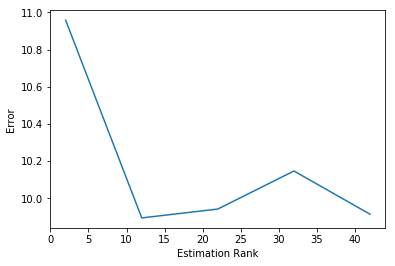

In [76]:
plt.plot(est_ranks,errors)
plt.xlabel('Estimation Rank')
plt.ylabel('Error ')
plt.show()

### Error vs Iteration Number & Estimation Rank

In [169]:
est_ranks = np.arange(2, 51, 5)
iter_number = np.arange(100, 3001, 500) 


n = est_ranks.shape[0]
m = iter_number.shape[0]

errors4 = np.zeros((n , m ))



ee = 0 
# 20 dk suruyor 
for e in iter_number:
    kk = 0
    for k in est_ranks:
        
        original_matrix = np.array([[int((i + j) % 2 == 0) for j in range(M)] for  i in range(M)])
        mask = generate_mask(M)
        
        W, H, sgd_error_vec = sgd(original_matrix, mask, k , max_epoch= e ,eta=0.010)

        temp_error = sgd_error_vec[-1]
        
        errors4[kk,ee] = temp_error
        kk = kk + 1
        
    ee = ee + 1




100
600
1100
1600
2100
2600


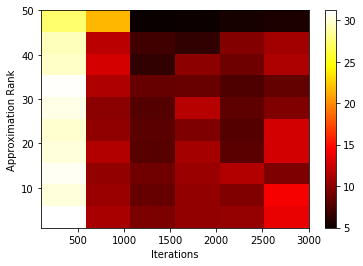

In [171]:
plt.imshow(errors4, cmap='hot', interpolation='nearest', extent=[100,3000,1,M], aspect='auto')
plt.xlabel('Iterations')
plt.ylabel('Approximation Rank')
plt.colorbar()
plt.show()

### Error vs Mask Count & Estimation Rank

In [122]:
est_ranks = np.arange(2, 51, 5)
mask_count = np.arange(100, 1501, 300)

n = est_ranks.shape[0]
m = mask_count.shape[0]

errors5 = np.zeros((n , m ))

In [123]:
errors5

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [124]:
mcc = 0 
# dk suruyor
for mc in mask_count:
    print mc
    kk = 0
    for k in est_ranks:
        
        original_matrix = np.array([[int((i + j) % 2 == 0) for j in range(M)] for  i in range(M)])
        
        mask = generate_mask(M, mc)
        
        W, H, sgd_error_vec = sgd(original_matrix, mask, k , max_epoch= 1000 ,eta=0.10)

        temp_error = sgd_error_vec[-1]
        
        errors5[kk,mcc] = temp_error
        kk = kk + 1
        
    mcc = mcc + 1




100


/Users/yigitokar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


400
700
1000
1300


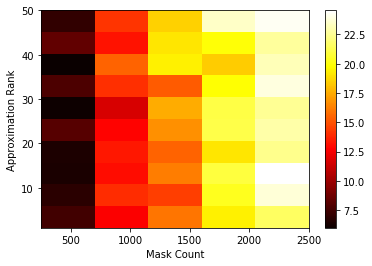

In [125]:
plt.imshow(errors5, cmap='hot', interpolation='nearest', extent=[250,2500,1,50], aspect='auto')
plt.xlabel('Mask Count')
plt.ylabel('Approximation Rank')
plt.colorbar()
plt.show()

# PyTorch


In [43]:
import torch

In [44]:
def forward_pass(W,H,MM ,Y_M):
    
    WH = torch.mm(W,H)
    WH = WH.type(torch.DoubleTensor)
    dum1 = torch.mul(MM,Y_M)
    A = torch.mul(dum1,WH)
    sum_A = A.sum()
    B = torch.mul(MM, torch.log(1 + torch.exp(WH)))
    sum_B = B.sum()
    LL = sum_A - sum_B
    
    return(LL)


In [45]:
def pointwise_forward_ll(W,H,MM ,Y_M,i,j):
    
    WH = torch.mm(W,H)
    WH = WH.type(torch.DoubleTensor)
    dum1 = torch.mul(MM,Y_M)
    A = torch.mul(dum1,WH)
    B = torch.mul(MM, torch.log(1 + torch.exp(WH)))
    
    ll_ij = (A - B)[i,j]

    return(ll_ij)

# Vectoral Gradient Descent Using PyTorch

In [46]:
def GD_PyTorch(original_matrix, mask, K , max_epoch=10000,eta=0.010, nu=0.1): 
    M = 50 
    #K = 2
    Y = np.multiply(original_matrix, mask)
    Y_M = Y.copy()
    Y_M[np.isnan(Y_M)] = 999
    MM = mask.copy()  # creating a Mask matrix that is going to be used in GD.
    MM[np.isnan(MM)] = 0

    W = torch.randn(M, K, requires_grad=True)
    H = torch.randn(K, M, requires_grad=True)

    Y_M = torch.from_numpy(Y_M)
    MM = torch.from_numpy(MM)
    original_matrix = torch.from_numpy(original_matrix)
    original_matrix = original_matrix.type(torch.DoubleTensor)

    error_tensor = torch.zeros(max_epoch)
    for epoch in range(1000):

        LL = forward_pass(W,H,MM ,Y_M)
        LL.backward()

        dLh = H.grad.data - nu * H.data
        H.data = H.data + eta * dLh

        dLw = W.grad.data - nu * W.data
        W.data = W.data + eta * dLw

        H.grad.data.zero_()
        W.grad.data.zero_()

        Y_hat = torch.sigmoid(torch.mm(W.data,H.data))
        Y_hat = Y_hat.type(torch.DoubleTensor)
        Error_Matrix = Y_hat - original_matrix
        error_tensor[epoch] = Error_Matrix.norm()

    plt.plot(error_tensor.data.numpy()[0:epoch])
    plt.show()
    Y_hat = torch.sigmoid(torch.mm(W,H)).data.numpy()

    return(W.data,H.data,error_tensor)


In [47]:
# RE-initialize
original_matrix = np.array([[int((i + j) % 2 == 0) for j in range(M)] for  i in range(M)])
mask = generate_mask(M)

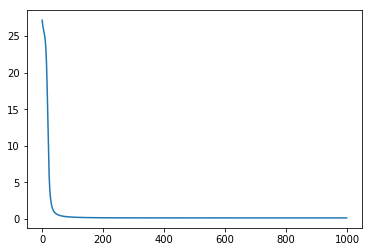

In [48]:
W,H,error_tensor = GD_PyTorch(original_matrix, mask, 2 , max_epoch=10000,eta=0.010, nu=0.1)

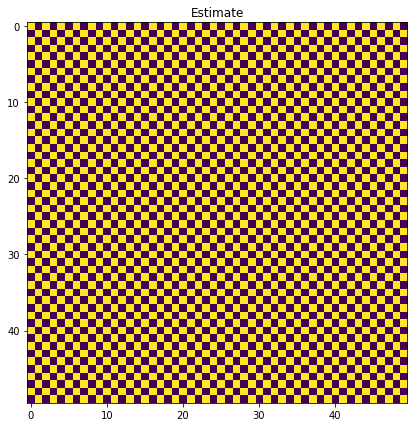

In [49]:
Y_hat = torch.sigmoid(torch.mm(W,H)).data.numpy()
plt.figure(figsize = (7,7))
plt.imshow(Y_hat, interpolation='nearest')  
plt.title('Estimate')
plt.show()

# Stochastic Gradient Descent Using PyTorch

In [50]:
def SGD_PyTorch(original_matrix, mask, K , max_epoch,eta=0.010): 
    
    M=50 
    Y = np.multiply(original_matrix, mask)
    Y_M = Y.copy()
    Y_M[np.isnan(Y_M)] = 999
    MM = mask.copy()  # creating a Mask matrix that is going to be used in GD.
    MM[np.isnan(MM)] = 0

    


    # Create random Tensors for W and H

    torch.manual_seed(2)
    W = torch.randn(M, K, requires_grad=True)
    H = torch.randn(K, M, requires_grad=True)

    Y_M = torch.from_numpy(Y_M)
    MM = torch.from_numpy(MM)
    original_matrix = torch.from_numpy(original_matrix)
    original_matrix = original_matrix.type(torch.DoubleTensor)
    
    
    sgd_error_tensor = torch.zeros(max_epoch) #initialize the error tensor
    
    # SGD starts here 
    for epoch in range(max_epoch):

        j = torch.LongTensor(1).random_(0, 50)
        i = torch.LongTensor(1).random_(0, 50)

        ll_ij = pointwise_forward_ll(W,H,MM ,Y_M,i,j)
        ll_ij.backward()

        dLh = H.grad.data 
        H.data = H.data + eta * dLh

        dLw = W.grad.data 
        W.data = W.data + eta * dLw

        H.grad.data.zero_()
        W.grad.data.zero_()

        Y_hat = torch.sigmoid(torch.mm(W.data,H.data))
        Y_hat = Y_hat.type(torch.DoubleTensor)
        Error_Matrix = Y_hat - original_matrix
        sgd_error_tensor[epoch] = Error_Matrix.norm()
    
    
    #plt.plot(sgd_error_tensor.data.numpy()[0:epoch])
    #plt.show()
    
    return(W.data,H.data,sgd_error_tensor)

In [51]:
# RE-initialize
original_matrix = np.array([[int((i + j) % 2 == 0) for j in range(M)] for  i in range(M)])
mask = generate_mask(M)

In [52]:
W,H,sgd_error_tensor = SGD_PyTorch(original_matrix, mask, K = 2 , max_epoch=10000,eta=0.10)

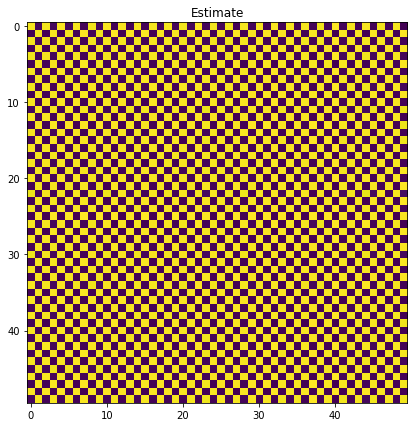

In [53]:
Y_hat = torch.sigmoid(torch.mm(W,H)).data.numpy()
plt.figure(figsize = (7,7))
plt.imshow(Y_hat, interpolation='nearest')  
plt.title('Estimate')
plt.show()


# Mini-Batch Gradient Descent  Using PyTorch

In [54]:
def MiniBatch_SGD_PyTorch(original_matrix, mask, K , max_epoch=10000,eta=0.010, B = 10): 
    M=50 
    Y = np.multiply(original_matrix, mask)
    Y_M = Y.copy()
    Y_M[np.isnan(Y_M)] = 999
    MM = mask.copy()  
    MM[np.isnan(MM)] = 0

    # Create random Tensors for W and H

    torch.manual_seed(2)
    W = torch.randn(M, K, requires_grad=True)
    H = torch.randn(K, M, requires_grad=True)

    Y_M = torch.from_numpy(Y_M)
    MM = torch.from_numpy(MM)
    original_matrix = torch.from_numpy(original_matrix)
    original_matrix = original_matrix.type(torch.DoubleTensor)
    
    minibatch_error_tensor = torch.zeros(max_epoch) #initialize the error tensor
 
    # Minibatch SGD starts here 
    for epoch in range(max_epoch):
        dLh = torch.zeros(K,M)
        dLw = torch.zeros(M,K)
        batch = [ ( torch.LongTensor(1).random_(0, 50), torch.LongTensor(1).random_(0, 50) ) for k in range(B) ]
        for b in range(B):
            i,j = batch[b]
            ll_ij = pointwise_forward_ll(W,H,MM ,Y_M,i,j)
            ll_ij.backward()

            dLh.data = dLh.data + H.grad.data
            dLw.data = dLw.data + W.grad.data

            H.grad.data.zero_()
            W.grad.data.zero_()

        H.data = H.data + eta * dLh.data
        W.data = W.data + eta * dLw.data

        Y_hat = torch.sigmoid(torch.mm(W.data,H.data))
        Y_hat = Y_hat.type(torch.DoubleTensor)
        Error_Matrix = Y_hat - original_matrix
        minibatch_error_tensor[epoch] = Error_Matrix.norm()
    
    
    
    plt.plot(minibatch_error_tensor.data.numpy()[0:epoch])
    plt.show()
    return(W.data,H.data,minibatch_error_tensor)

In [55]:
# RE-initialize
original_matrix = np.array([[int((i + j) % 2 == 0) for j in range(M)] for  i in range(M)])
mask = generate_mask(M)

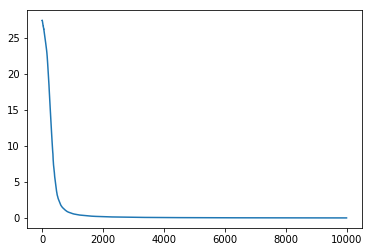

In [56]:
W,H,sgd_error_tensor = MiniBatch_SGD_PyTorch(original_matrix, mask, K = 2 , max_epoch=10000, eta=0.10, B=10)

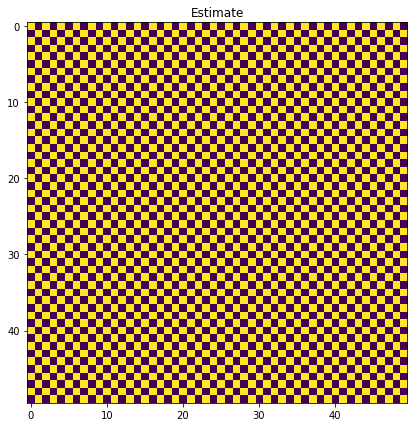

In [57]:
Y_hat = torch.sigmoid(torch.mm(W,H)).data.numpy()
plt.figure(figsize = (7,7))
plt.imshow(Y_hat, interpolation='nearest')  
plt.title('Estimate')
plt.show()



# Error Plots

### Error vs Estimation Rank

In [90]:
W, H, sgd_error_tensor = SGD_PyTorch(original_matrix, mask, 50 , max_epoch=7000,eta=0.020)
sgd_error_tensor[-1]

tensor(22.5721)

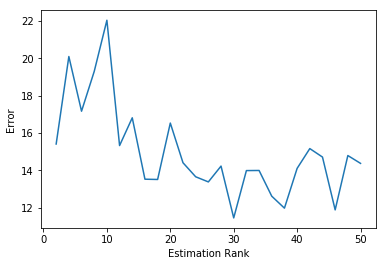

In [108]:
# 5 dk suruyor

est_ranks = np.arange(2, 51, 2)

error = []
for k in est_ranks:
    #print k
    original_matrix = np.array([[int((i + j) % 2 == 0) for j in range(M)] for  i in range(M)])
    mask = generate_mask(M)
    W, H, sgd_error_tensor = SGD_PyTorch(original_matrix, mask, k , max_epoch=5000,eta=0.050)
    temp_error = sgd_error_tensor[-1]
    error.append(temp_error.data.numpy())

plt.plot(est_ranks,error)
plt.xlabel('Estimation Rank')
plt.ylabel('Error ')
plt.show()

### Error vs Itereation number & Estimation Rank

In [110]:
est_ranks = np.arange(2, 51, 2)
iter_number = np.arange(5000, 20001, 2000)

n = est_ranks.shape[0]
m = iter_number.shape[0]

errors = np.zeros((n , m ))

In [111]:
ee = 0 
# 20 dk suruyor 
for e in iter_number:
    print e 
    kk = 0
    for k in est_ranks:
        
        original_matrix = np.array([[int((i + j) % 2 == 0) for j in range(M)] for  i in range(M)])
        mask = generate_mask(M)
        
        W, H, sgd_error_tensor = SGD_PyTorch(original_matrix, mask, k , max_epoch= e ,eta=0.10)

        temp_error = sgd_error_tensor[-1]
        
        errors[kk,ee] = temp_error.data.numpy()
        kk = kk + 1
        
    ee = ee + 1



    


5000
7000
9000
11000
13000
15000
17000
19000


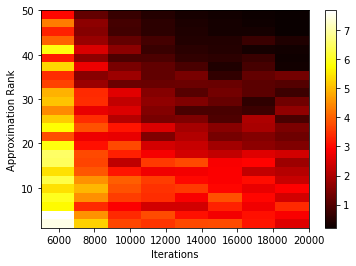

In [112]:
plt.imshow(errors, cmap='hot', interpolation='nearest', extent=[5000,20000,1,M], aspect='auto')
plt.xlabel('Iterations')
plt.ylabel('Approximation Rank')
plt.colorbar()
plt.show()

Theoretically, we expect that when approximation rank is getting bigger and number of iterations is getting bigger, error decreases. Our expectations are satisfied.

### Error vs Mask Count & Estimation Rank

In [113]:
est_ranks = np.arange(2, 51, 2)
mask_count = np.arange(100, 1501, 250)

n = est_ranks.shape[0]
m = mask_count.shape[0]

errors2 = np.zeros((n , m ))

In [114]:
print est_ranks
print mask_count

[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50]
[ 100  350  600  850 1100 1350]


In [115]:
mcc = 0 
# dk suruyor
for mc in mask_count:
    print mc
    kk = 0
    for k in est_ranks:
        
        original_matrix = np.array([[int((i + j) % 2 == 0) for j in range(M)] for  i in range(M)])
        
        mask = generate_mask(M, mc)
        
        W, H, sgd_error_tensor = SGD_PyTorch(original_matrix, mask, k , max_epoch= 5000 ,eta=0.10)

        temp_error = sgd_error_tensor[-1]
        
        errors2[kk,mcc] = temp_error.data.numpy()
        kk = kk + 1
        
    mcc = mcc + 1



100
350
600
850
1100
1350


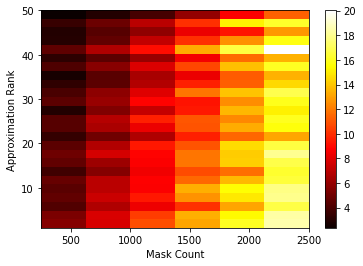

In [116]:
plt.imshow(errors2, cmap='hot', interpolation='nearest', extent=[250,2500,1,50], aspect='auto')
plt.xlabel('Mask Count')
plt.ylabel('Approximation Rank')
plt.colorbar()
plt.show()

Similarly, results are consistent. Theoretically, we expect that when approximation rank is getting bigger and mask count is decreasing, error decreases. Our expectations are satisfied.